# Qrylov

## Setup

In [52]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import openfermion as of

In [53]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray],
    matrix: np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(i, j)
            hij = vectors[i].conj().T @ matrix @ vectors[j]
            h[i, j] = hij

            if i != j:
                h[j, i] = np.conjugate(hij)

            sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s


# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
) -> float:
    if np.isclose(threshold, 0, atol=1e-10):
        h_reg = h
        s_reg = s
    else:
        s_vals, s_vecs = sp.linalg.eigh(s)
        s_vecs = s_vecs.T
        good_vecs = np.array(
            [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
        )
        h_reg = good_vecs.conj() @ h @ good_vecs.T
        s_reg = good_vecs.conj() @ s @ good_vecs.T
        return sp.linalg.eigh(h_reg, s_reg)[0][0]

## Problem definition

In [54]:
hamiltonian = of.jordan_wigner(
    of.hamiltonians.fermi_hubbard(
        x_dimension=2,
        y_dimension=2,
        tunneling=1.0,
        coulomb=1.0,
        periodic=False,
    )
)
nqubits = of.utils.count_qubits(hamiltonian)
nqubits

8

In [55]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)
matrix = hamiltonian_cirq.matrix()

In [56]:
evals_exact, evecs_exact = np.linalg.eigh(matrix)
ground_state = evecs_exact.T[0]
energy_exact = min(evals_exact)
energy_exact

-3.785260864829659

## Parameters

In [57]:
subspace_dimension: int = 15
threshold: float = 1e-4

In [58]:
bvec = ground_state + np.random.randn(ground_state.shape[0]) / 1.0
bvec /= np.linalg.norm(bvec)

overlap = np.abs(bvec.conj().T @ ground_state) ** 2
overlap

0.015573348541901667

## Krylov with $H$

In [59]:
vectors = [bvec]
for i in range(subspace_dimension - 1):
    vectors.append(
        matrix @ vectors[-1]
    )

/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1531833945.py:4: RuntimeWarning: divide by zero encountered in matmul
  matrix @ vectors[-1]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1531833945.py:4: RuntimeWarning: overflow encountered in matmul
  matrix @ vectors[-1]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1531833945.py:4: RuntimeWarning: invalid value encountered in matmul
  matrix @ vectors[-1]


In [60]:
h, s = fill_h_and_s_matrices(vectors, matrix)

/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: divide by zero encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: overflow encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: invalid value encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]


In [61]:
krylov_evals = []
for d in range(1, len(h) + 1):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_evals.append(krylov_energy)

0.8188172491335913
-1.1072190279273189
-2.5107311116772637
-3.1890682583661083
-3.4785371851170668
-3.601091461114777
-3.6590385002760732
-3.70214705510262
-3.7339404115847845
-3.7553455417009696
-3.7679831860487716
-3.7750444695474963
-3.7782637202570943
-3.7810240450439023
-3.7828956157736418


/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:43: RuntimeWarning: divide by zero encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:43: RuntimeWarning: overflow encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:43: RuntimeWarning: invalid value encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:44: RuntimeWarning: divide by zero encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:44: RuntimeWarning: overflow encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:44: RuntimeWarning: invalid v

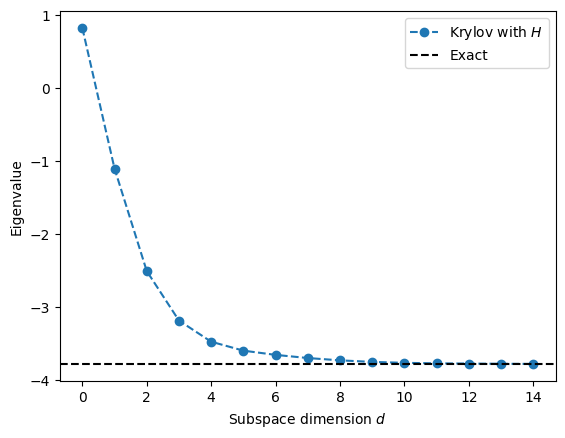

In [62]:
err = np.abs(krylov_energy - energy_exact)
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.legend();

### Unitary Krylov

In [63]:
# See Theorem 3.1 of https://arxiv.org/abs/2110.07492.
dt = np.pi / (evals_exact[-1] - evals_exact[0])
dt

0.3117212236708433

In [64]:
vectors_u = []
for k in range(-subspace_dimension // 2, subspace_dimension // 2 + 1, 1):
    print(k)
    Uk = sp.linalg.expm(-1j * matrix * k * dt)
    vectors_u.append(Uk @ bvec)

-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1061688123.py:5: RuntimeWarning: divide by zero encountered in matmul
  vectors_u.append(Uk @ bvec)
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1061688123.py:5: RuntimeWarning: overflow encountered in matmul
  vectors_u.append(Uk @ bvec)
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/1061688123.py:5: RuntimeWarning: invalid value encountered in matmul
  vectors_u.append(Uk @ bvec)


In [65]:
h, s = fill_h_and_s_matrices(vectors_u, matrix)

/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: divide by zero encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: overflow encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_56704/2974860614.py:14: RuntimeWarning: invalid value encountered in matmul
  hij = vectors[i].conj().T @ matrix @ vectors[j]


In [66]:
krylov_u_evals = []
for d in range(1, len(h)):
    krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_evals.append(krylov_energy)

0.8188172491335914
-0.9271493726525736
-2.235834653759868
-2.9803979376658365
-3.3503678581402268
-3.5296516861224956
-3.4754819218456516
-3.5778202573865894
-3.6375132421549985
-3.6087065065325774
-3.6611778043240597
-3.7019871410738574
-3.6807638243680474
-3.7197951157778197
-3.7005904805393466


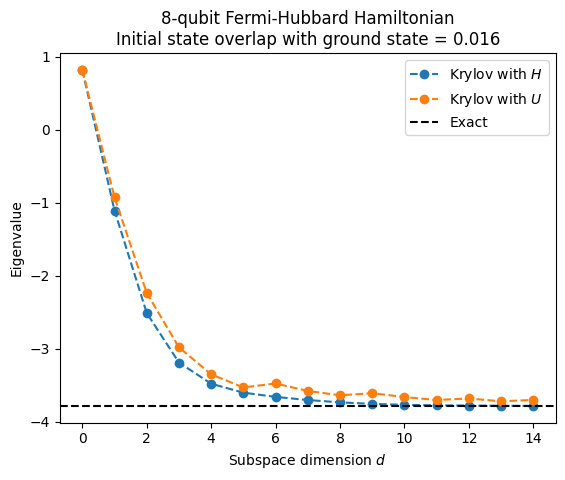

In [67]:
plt.plot(krylov_evals, "--o", label="Krylov with $H$")
plt.plot(krylov_u_evals, "--o", label="Krylov with $U$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.legend();

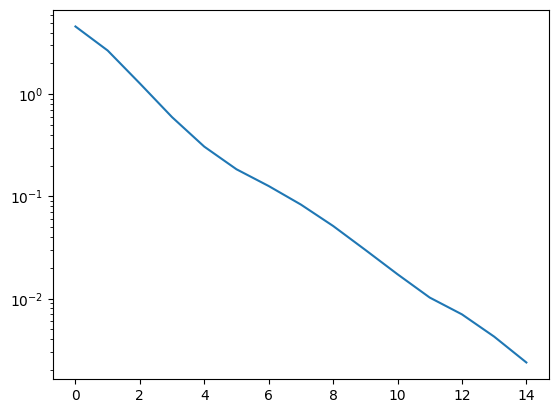

In [68]:
fig, ax = plt.subplots()
err = np.abs(krylov_evals - energy_exact)
ax.plot(err)
ax.set_yscale("log")